In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
pip install quandl

In [3]:
import quandl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Dropout, Input, SimpleRNN, Flatten, GRU, LSTM, GlobalMaxPool1D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# ford = quandl.get("EOD/F", authtoken="jRxPTsT3VB8aRYyEzc-M", start_date="2012-01-01")

# **Autoregressive model (AR)**

### **Build the synthetic dataset**


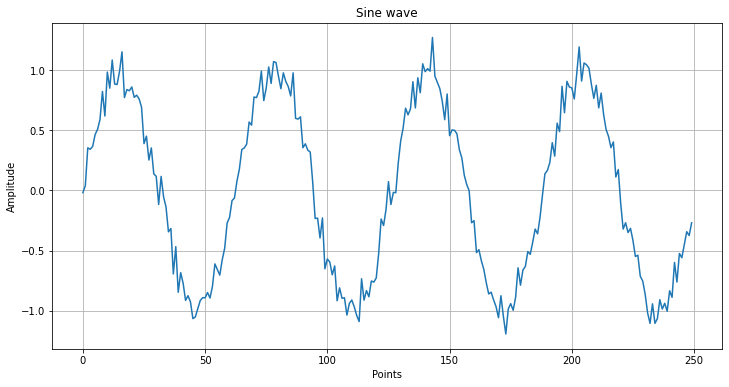

In [63]:
# Sine wave with 250 points
series = np.sin(0.1*np.arange(250))   + np.random.randn(250)*0.1

# Label the graph
plt.figure(figsize=(12,6))
plt.title('Sine wave')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)

# plot the sin wave
plt.plot(series)
plt.show()

In [64]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (240, 10) Y.shape (240,)


### **Autoregressive linear model**

In [65]:
### Build the autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the model
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=100,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2668 - val_loss: 0.0963
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0961 - val_loss: 0.1341
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0666 - val_loss: 0.0729
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0682 - val_loss: 0.0305
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0607 - val_loss: 0.0482
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0373 - val_loss: 0.0610
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0437 - val_loss: 0.0301
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0334 - val_loss: 0.0237
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 10/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0249 - val_loss: 0.0262
Epoch 11/100
4/4 [==========

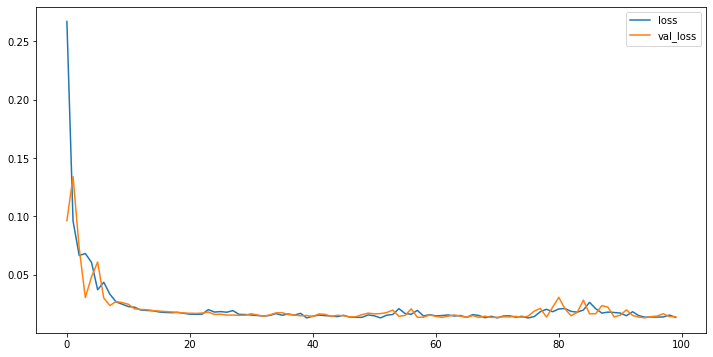

In [66]:
# loss per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### **Forecast prediction**

#### **One step forecast**

In [67]:
# One step forecast using true targets
validation_target = Y[-N//2:] # second half of Y
validation_predictions = [] # Create empty list for the validations predictions

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target): #make all the predictions corresponding to the targets
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 - one sample of T features 
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

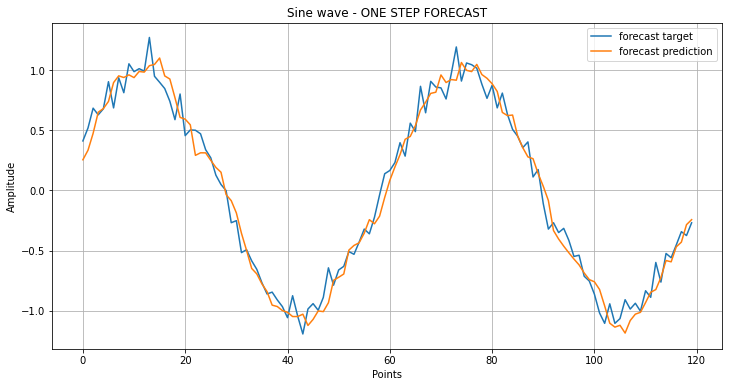

In [68]:
# Label the graph
plt.figure(figsize=(12,6))

# Label the graph
plt.title('Sine wave - ONE STEP FORECAST')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

#### **Multi step forecast**

In [69]:
# Forecast future values (use only self-predictions for making future predictions)
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

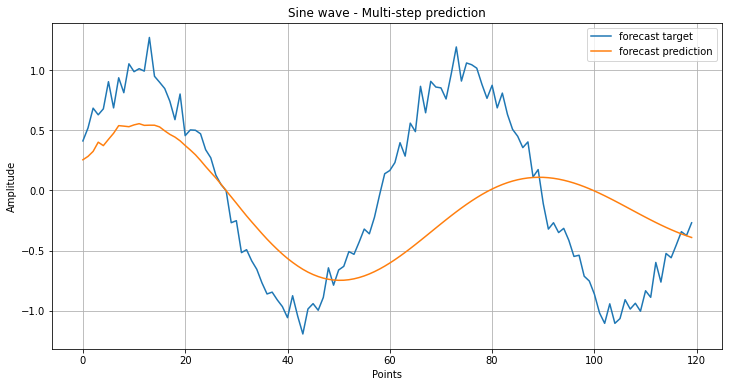

In [70]:
plt.figure(figsize=(12,6))
plt.title('Sine wave - Multi-step prediction')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

# **Simple RNN model**

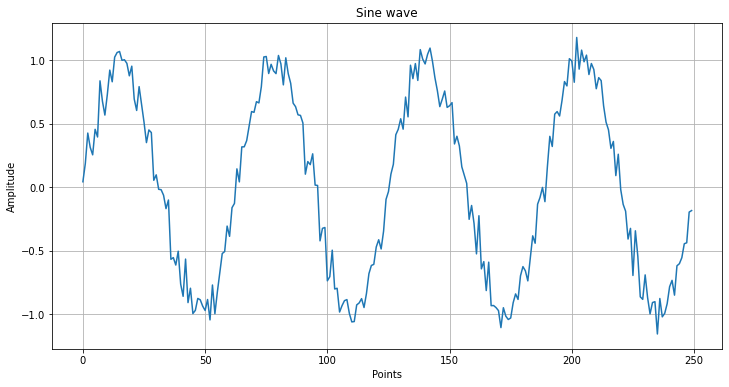

In [13]:
# Sine wave with 250 points
series = np.sin(0.1*np.arange(250)) + np.random.randn(250)*0.1

# Label the graph
plt.figure(figsize=(12,6))
plt.title('Sine wave')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)

# plot the sin wave
plt.plot(series)
plt.show()

### **Buil the synthetic dataset**

In [14]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (240, 10, 1) Y.shape (240,)


### **Simple RNN model**

Remember to set the activation function to none


In [15]:
### simple RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=100,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100
4/4 [==============================] - 0s 41ms/step - loss: 0.4590 - val_loss: 0.1033
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0434
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0371 - val_loss: 0.0262
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0322 - val_loss: 0.0338
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0334 - val_loss: 0.0298
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0308 - val_loss: 0.0238
Epoch 7/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0253 - val_loss: 0.0240
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0248 - val_loss: 0.0221
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0227 - val_loss: 0.0214
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0224 - val_loss: 0.0220
Epoch 11/100
4/4 [=

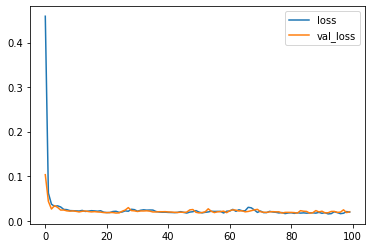

In [16]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### **Forecast prediction**

#### **One step forecast**

In [17]:
# One step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

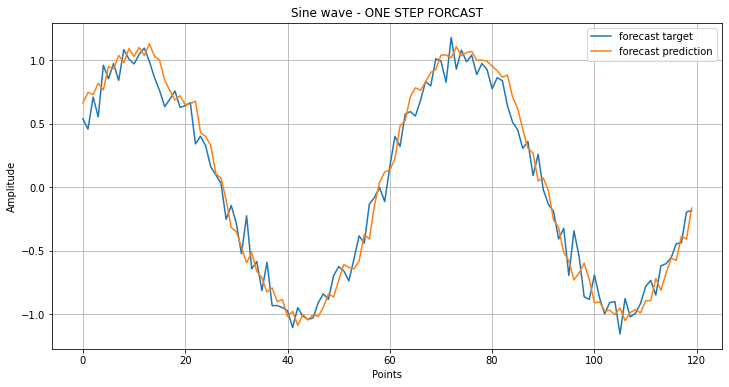

In [18]:
plt.figure(figsize=(12,6))
plt.title('Sine wave - ONE STEP FORCAST')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

#### **Multi step forecast**


In [19]:
# Multi step forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

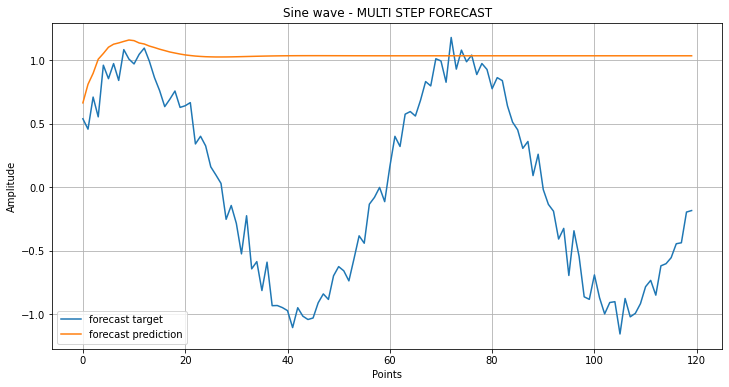

In [20]:
plt.figure(figsize=(12,6))
plt.title('Sine wave - MULTI STEP FORECAST')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

# **LSTM Nonlinear**


In [21]:
# make the original data
series = np.sin((0.1*np.arange(450))**2)

The time series here can be mathematically expressed as follows:
$$ x(t) = \sin(\omega t^2) $$

This is similar to the previous exercises. However, there is a subtle difference that is the input argument is being squared into the sine function. Because of the input argument is squared, this means that frequency and hence the period of the time wave changes over time. 

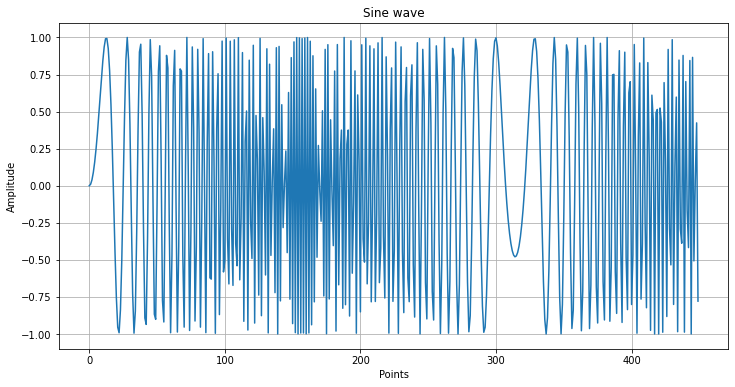

In [22]:
# Sine wave squared grahp
plt.figure(figsize=(12,6))
plt.plot(series)
plt.title('Sine wave')
plt.xlabel('Points')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### **Build the synthetic dataset**

In [23]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (440, 10) Y.shape (440,)


### **Comparison**

#### **Autoregressive linear model**

In [24]:
### Autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the model
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
7/7 [==============================] - 0s 12ms/step - loss: 1.1665 - val_loss: 1.2932
Epoch 2/80
7/7 [==============================] - 0s 6ms/step - loss: 1.0020 - val_loss: 1.1276
Epoch 3/80
7/7 [==============================] - 0s 7ms/step - loss: 0.8887 - val_loss: 0.9631
Epoch 4/80
7/7 [==============================] - 0s 6ms/step - loss: 0.7788 - val_loss: 0.8385
Epoch 5/80
7/7 [==============================] - 0s 7ms/step - loss: 0.7070 - val_loss: 0.7371
Epoch 6/80
7/7 [==============================] - 0s 7ms/step - loss: 0.6397 - val_loss: 0.6651
Epoch 7/80
7/7 [==============================] - 0s 7ms/step - loss: 0.5921 - val_loss: 0.6170
Epoch 8/80
7/7 [==============================] - 0s 6ms/step - loss: 0.5589 - val_loss: 0.5814
Epoch 9/80
7/7 [==============================] - 0s 7ms/step - loss: 0.5299 - val_loss: 0.5635
Epoch 10/80
7/7 [==============================] - 0s 6ms/step - loss: 0.5106 - val_loss: 0.5550
Epoch 11/80
7/7 [=====================

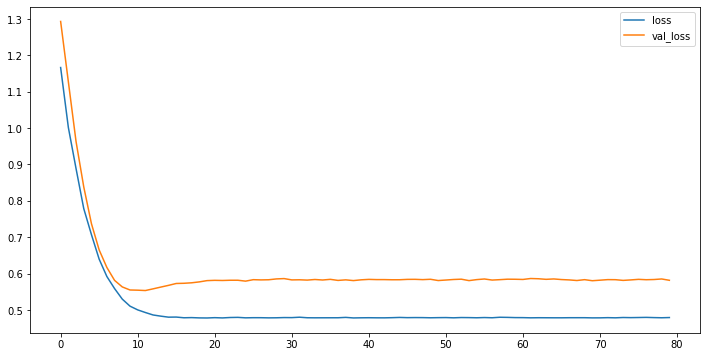

In [25]:
# loss per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

##### **One-step forecast**

(440, 1)


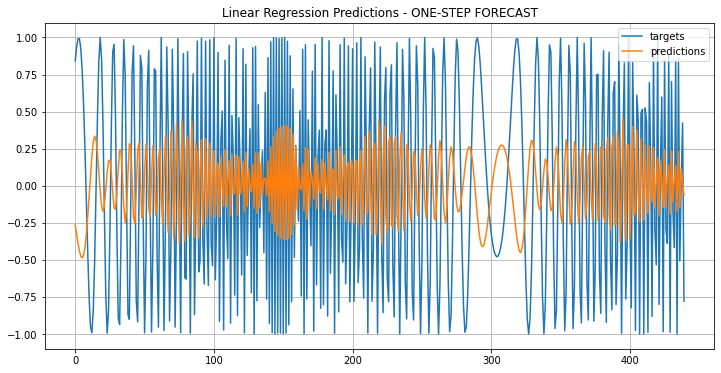

In [26]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(12,6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions - ONE-STEP FORECAST")
plt.grid(True)
plt.legend()
plt.show()

##### **Multi-step forecast**

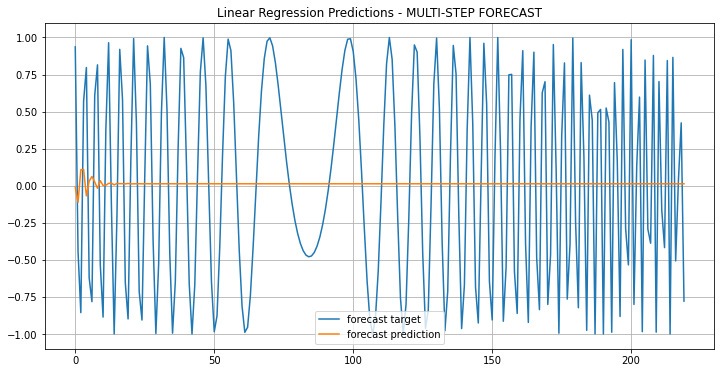

In [27]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.figure(figsize=(12,6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.title("Linear Regression Predictions - MULTI-STEP FORECAST")
plt.grid(True)
plt.legend()
plt.show()

#### **RNN/LSTM model**

In [28]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i) # Change to LSTM to see the comparison
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=30,
  epochs=220,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/220
8/8 [==============================] - 0s 42ms/step - loss: 0.5291 - val_loss: 0.5630
Epoch 2/220
8/8 [==============================] - 0s 7ms/step - loss: 0.4966 - val_loss: 0.5243
Epoch 3/220
8/8 [==============================] - 0s 7ms/step - loss: 0.4670 - val_loss: 0.5489
Epoch 4/220
8/8 [==============================] - 0s 7ms/step - loss: 0.3571 - val_loss: 0.4990
Epoch 5/220
8/8 [==============================] - 0s 7ms/step - loss: 0.2756 - val_loss: 0.4369
Epoch 6/220
8/8 [==============================] - 0s 7ms/step - loss: 0.2197 - val_loss: 0.3031
Epoch 7/220
8/8 [==============================] - 0s 7ms/step - loss: 0.1711 - val_loss: 0.2852
Epoch 8/220
8/8 [==============================] - 0s 7ms/step - loss: 0.1210 - val_loss: 0.2077
Epoch 9/220
8/8 [==============================] - 0s 7ms/step - loss: 0.0833 - val_loss: 0.2246
Epoch 10/220
8/8 [==============================] - 0s 7ms/step - loss: 0.0608 - val_loss: 0.1889
Epoch 11/220
8/8 [==========

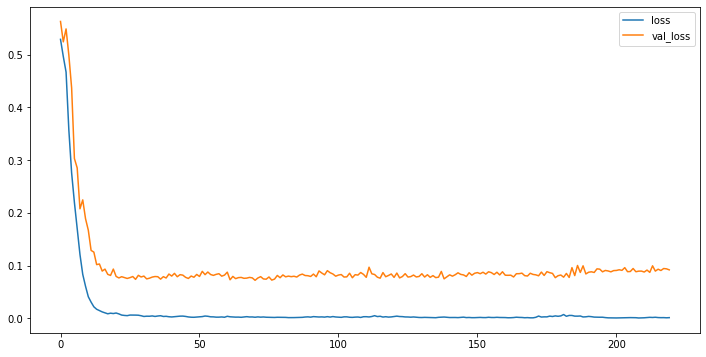

In [29]:
# plot loss per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(440, 1)


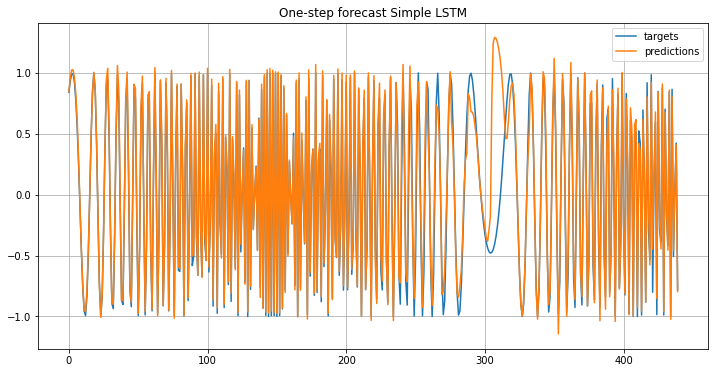

In [30]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(12,6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("One-step forecast Simple LSTM")
plt.grid(True)
plt.legend()
plt.show()

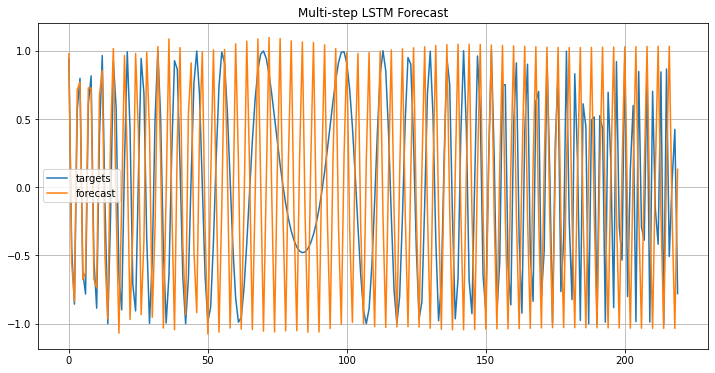

In [31]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.figure(figsize=(12,6))
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("Multi-step LSTM Forecast")
plt.grid(True)
plt.legend()
plt.show()

RNNs and LSTM show a very similar result. But why this may be case? LSTM is more popular and perfrom better at finding log term dependencies. However, that does not mean that LSTM is better and can do everything. Although, LSTM is good at finding long term dependencies, it is important to note that this is not the case for arbitrarily long term dependencies. There is a point where LSTM forget. Even that point is farther than the Simple RNN, it exists nevertheless. lecture 49 towards the end###########- 

# **Stock market prediction using LSTMs**

### **Stock price**

In [32]:
tesla = quandl.get("EOD/TSLA", authtoken="jRxPTsT3VB8aRYyEzc-M", start_date="2015-02-01", end_date="2020-02-01")

In [33]:
tesla = tesla[['Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume']]

In [34]:
tesla.head()

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,
2015-02-02,203.97,211.9499,203.3000,210.94,4149186.0
2015-02-03,213.22,220.3700,211.2700,218.36,4826244.0
2015-02-04,218.29,221.4790,216.8000,218.55,3305377.0
2015-02-05,219.88,225.4800,219.6380,220.99,3522947.0
2015-02-06,222.00,223.4000,216.5001,217.36,3243931.0


In [35]:
tesla.tail()

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,
2020-01-27,541.99,564.4400,539.28,558.02,13608068.0
2020-01-28,568.49,576.8100,558.08,566.90,11636523.0
2020-01-29,575.69,589.7999,567.43,580.99,18216672.0
2020-01-30,632.42,650.8800,618.00,640.81,29005676.0
2020-01-31,640.00,653.0000,632.52,650.57,15719266.0


In [36]:
# Predict the adj_close
series = tesla['Adj_Close'].values.reshape(-1, 1)

In [37]:
#Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [38]:
# Build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [39]:
# Build the LSTM 
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the LSTM
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 19ms/step - loss: 0.2168 - val_loss: 0.6462
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0324 - val_loss: 0.4344
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0254 - val_loss: 0.3823
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.3342
Epoch 5/80
20/20 [==============================] - 0s 5ms/step - loss: 0.0196 - val_loss: 0.3561
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0191 - val_loss: 0.3525
Epoch 7/80
20/20 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.3661
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.3739
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0206 - val_loss: 0.3428
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.3587
Epoch 11/80
20/20 

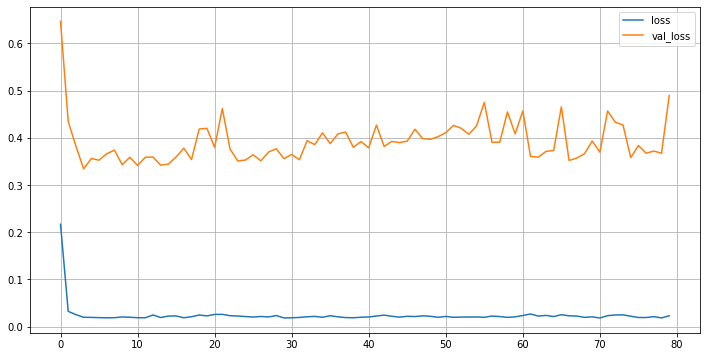

In [40]:
# Plot loss per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.grid(True)
plt.legend()
plt.show()

#### **One-step prediction**

(1249, 1)


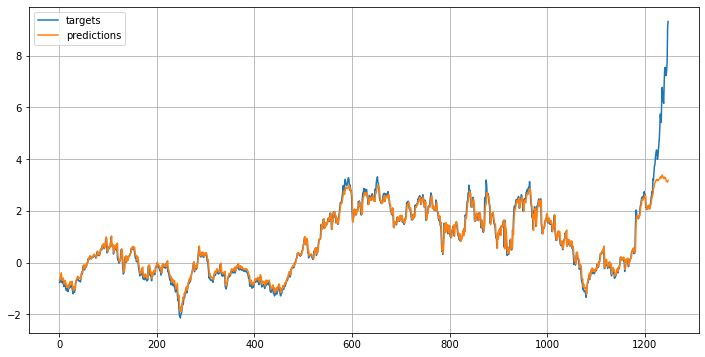

In [41]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(12,6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.grid(True)
plt.legend()
plt.show()

#### **Multi-step forecast**

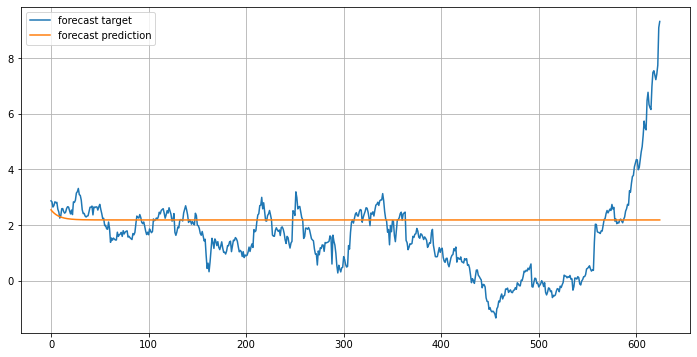

In [42]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.figure(figsize=(12,6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.grid(True)
plt.legend()
plt.show()

### **Stock return**

Po = initial stock price

P1 = Ending stock price

$$ Total Stock Return = \frac{P_1-P_0}{P_0}  $$


Caluate the returns by shifting the data up.

E.g

close / prev close
- x[2] x[1]
- x[3] x[2]
- x[4] x[3]
- ...
- x[t] x[t-1]

In [43]:
tesla['PrevClose'] = tesla['Adj_Close'].shift(1)

In [44]:
tesla.head()

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,PrevClose
Date,,,,,,
2015-02-02,203.97,211.9499,203.3000,210.94,4149186.0,NaN
2015-02-03,213.22,220.3700,211.2700,218.36,4826244.0,210.94
2015-02-04,218.29,221.4790,216.8000,218.55,3305377.0,218.36
2015-02-05,219.88,225.4800,219.6380,220.99,3522947.0,218.55
2015-02-06,222.00,223.4000,216.5001,217.36,3243931.0,220.99


In [45]:
tesla['Return'] = (tesla['Adj_Close'] - tesla['PrevClose']) / tesla['PrevClose']

In [46]:
tesla.head()

,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,PrevClose,Return
Date,,,,,,,
2015-02-02,203.97,211.9499,203.3000,210.94,4149186.0,NaN,NaN
2015-02-03,213.22,220.3700,211.2700,218.36,4826244.0,210.94,0.035176
2015-02-04,218.29,221.4790,216.8000,218.55,3305377.0,218.36,0.000870
2015-02-05,219.88,225.4800,219.6380,220.99,3522947.0,218.55,0.011164
2015-02-06,222.00,223.4000,216.5001,217.36,3243931.0,220.99,-0.016426


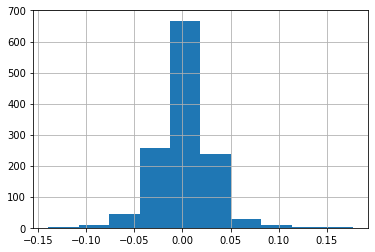

In [47]:
# Plost a histogram of the returns
# The values are small, therefore normalising data may help
tesla['Return'].hist()

In [48]:
series = tesla['Return'].values[1:].reshape(-1, 1)

# Normalise the data
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [49]:
# Build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [50]:
### Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN model
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=100,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/100
20/20 [==============================] - 0s 20ms/step - loss: 1.0287 - val_loss: 1.8274
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0131 - val_loss: 1.8316
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0084 - val_loss: 1.8295
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0083 - val_loss: 1.8308
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0047 - val_loss: 1.8404
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0019 - val_loss: 1.8391
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9999 - val_loss: 1.8476
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9950 - val_loss: 1.8510
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.9931 - val_loss: 1.8564
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9939 - val_loss: 1.8559
Epoch 11

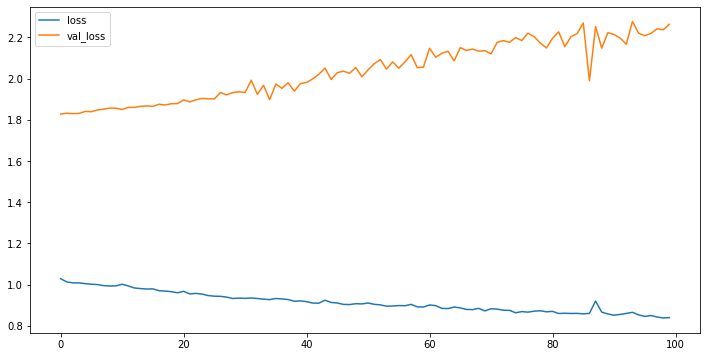

In [51]:
# Plot loss per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### **One-step forecast**

(1248, 1)


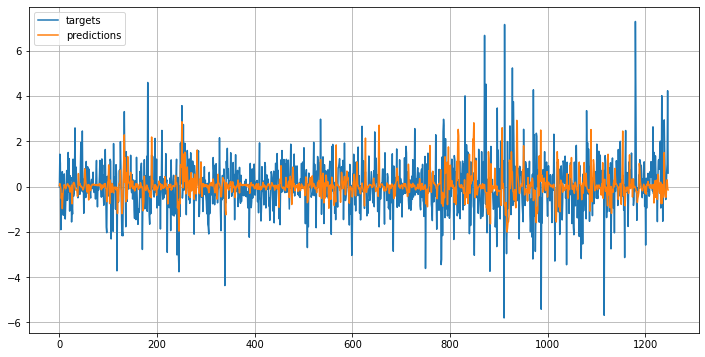

In [52]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.figure(figsize=(12,6))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.grid(True)
plt.legend()
plt.show()

#### **Multi-step forecast**

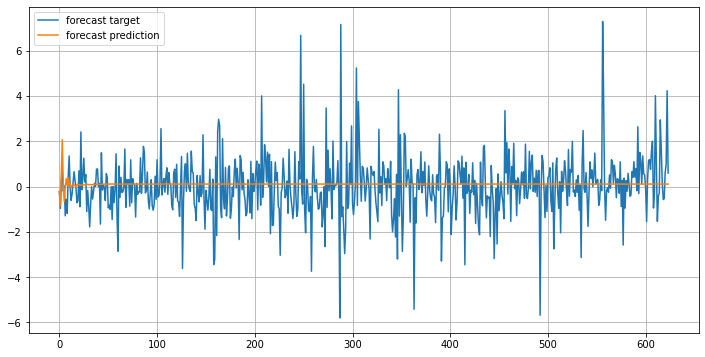

In [53]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.figure(figsize=(12,6))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.grid(True)
plt.legend()
plt.show()

### **Binary Classification**

In [54]:
# Turn th dataset into numpy arrays

# Not yet in the final "X" format!
input_data = tesla[['Adj_Open','Adj_High','Adj_Low','Adj_Close','Adj_Volume']].values
targets = tesla['Return'].values

In [55]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [56]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [57]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [58]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [59]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [60]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 0s 16ms/step - loss: 0.6980 - accuracy: 0.4756 - val_loss: 0.6929 - val_accuracy: 0.5098
Epoch 2/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5232 - val_loss: 0.6994 - val_accuracy: 0.4951
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5375 - val_loss: 0.7022 - val_accuracy: 0.5049
Epoch 4/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5280 - val_loss: 0.7064 - val_accuracy: 0.5098
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5316 - val_loss: 0.7072 - val_accuracy: 0.5049
Epoch 6/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5280 - val_loss: 0.7071 - val_accuracy: 0.5098
Epoch 7/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6911 - accuracy: 0.5113 - val_loss: 0.7090 - val_accuracy: 0.4878
Epoch 8/300


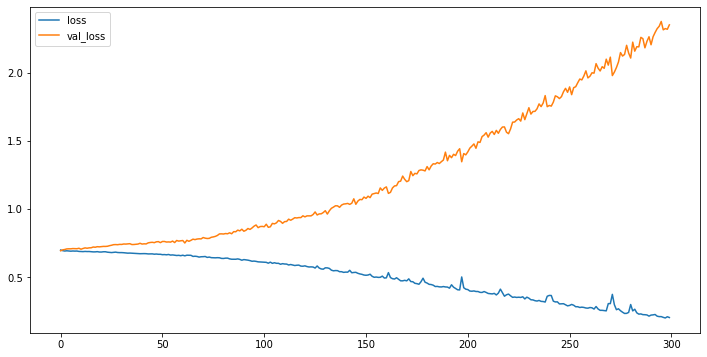

In [61]:
# plot the loss
plt.figure(figsize=(12,6))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

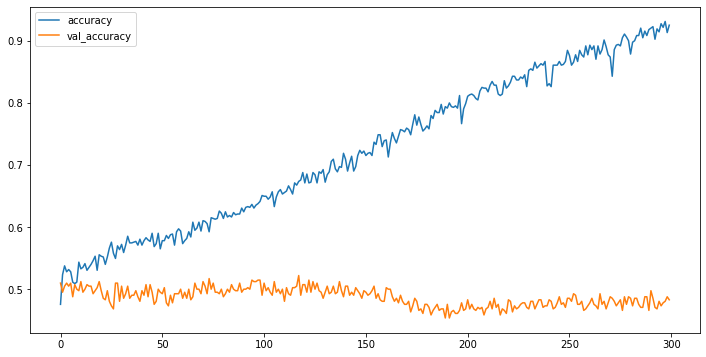

In [62]:
# Plot accuracy per iteration
plt.figure(figsize=(12,6))
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()